In [1]:
# %source '/home/hershel/root/root-6.26.00/install/bin/thisroot.sh'
import os
import sys
import ROOT

ROOT.EnableImplicitMT(True)
# ROOT.gInterpreter.GenerateDictionary("ROOT::VecOps::RVec<vector<double>>", "vector")
# ROOT.gInterpreter.Declare("ROOT::VecOps::RVec<vector<double>> bla;")
# ROOT.gSystem.Load("liblibs.so")
# ROOT.gSystem.Load("libQPixRTD.so")

def getRDFs(isofs):
    """
    function to create a dictionary of RDF's based on the isotope files handed to it
    """
    iso_rdfs = {}
    for isotope, files in isofs.items():
        iso_rdfs[isotope] = ROOT.RDataFrame("event_tree", files)

    return iso_rdfs

def getIsotopeFiles(fs):
    """
    this function should be able to return a RDF that corresponds to the preprend
    isotope
    """
    isotopes = set()

    # file structor is: /path/to/dir/00/iso_name_file.root
    # therefore rpartition for / and then partition on _ to separate for iso
    for f in fs:
        isotope = f.rpartition("/")[2].partition("_")
        isotopes.add(isotope[0])

    # create a dictionary of isotope to files
    isotope_files = {}
    for iso in isotopes:
        isotope_files[iso] = [f for f in fs if iso in f]

    return isotope_files


def getRootFiles():
    """
    this function should walk the radiogenic directory and spit back the file path
    of all ROOT files:

    note: you should be one directory above radiogenic
    """

    files = []
    for rs, ds, fs in os.walk("./radiogenic"):
        f = [f for f in fs if "root" in f]
        if f:
            f = [os.path.join(rs, f) for f in f ]
            files.extend(f)

    return files

def defineFilters(rdfs, xmin=80, xmax=120, ymin=80, ymax=120):
    """
    function takes in rdf dictionary and should define timestamp branch ond then filter
    on data to get the interesting events, or events that have timestamps at all
    """

    ROOT.gInterpreter.Declare("std::string isoname;")
    for iso, rdf in rdfs.items():
        # ROOT.isoname = iso;
        # rdfs[iso] = rdf.Define("Isotope", f'return isoname;')\
        #                .Filter(f"""bool found = false; 
        #                          for(auto x : pixel_x) 
        #                            if(x > {xmin} && x < {xmax}) found = true; 
        #                          return found;""")\
        #                .Filter(f"""bool found = false; 
        #                          for(auto y : pixel_y) 
        #                            if(y > {ymin} && y < {ymax}) found = true; 
        #                          return found;""")
        rdfs[iso] = rdf.Define("Isotope", f'return isoname;')\
                .Filter("""bool found = false; 
                            for(auto x : pixel_x) 
                            if(x > 80 && x <120) found = true; 
                            return found;""")
# run == some number maybe 00

    return rdfs

def main():
    files = getRootFiles()
    print(files[:10], len(files))

    isotopes = getIsotopeFiles(files)
    for k,v in isotopes.items():
        print(k, len(v))

    rdfs = getRDFs(isotopes)

    # figure out the interesting branch names in the tree
    branchNames = set()

    rdfs = defineFilters(rdfs)

    npData = {}
    for iso, rdf in rdfs.items():
        print(iso, rdf.GetColumnNames())
        # for col in rdf.GetColumnNames():
            # print(col, rdf.GetColumnType(col))
        # rdf.Snapshot("event_tree", f'./scripts/output_data/{iso}_sim.root')

        print(rdf.Count().GetValue())
        h1 = rdf.Histo1D("event")
        # c1 = ROOT.TCanvas()
        h1.Draw()
        # c1.Draw()
        # print('histo has been drawn')
        npData[iso] = rdf.AsNumpy(["pixel_x", "pixel_y", "pixel_tslr", "pixel_reset", "run", "event"])

    for iso, data in npData.items():
        for col, npd in data.items():
            print(iso ,col, len(npd))
    
    return npData

    # input("waiitng..")



# if __name__ == "__main__":
#     main()


Welcome to JupyROOT 6.26/00


In [2]:
%pwd
os.chdir('/home/hershel/QPix/')

data = main()


['./radiogenic/41/Rn222_rtd_slim_000041.root', './radiogenic/41/K40_rtd_slim_000041.root', './radiogenic/41/Ar39_rtd_slim_000041.root', './radiogenic/41/Ar42_rtd_slim_000041.root', './radiogenic/41/Bi214_rtd_slim_000041.root', './radiogenic/41/Pb214_rtd_slim_000041.root', './radiogenic/41/K42_rtd_slim_000041.root', './radiogenic/41/Po210_rtd_slim_000041.root', './radiogenic/41/Co60_rtd_slim_000041.root', './radiogenic/41/Kr85_rtd_slim_000041.root'] 1000
Rn222 100
Pb214 100
Co60 100
K42 100
K40 100
Ar42 100
Bi214 100
Po210 100
Kr85 100
Ar39 100
Rn222 { "Isotope", "energy_deposit", "event", "pixel_reset", "pixel_tslr", "pixel_x", "pixel_y", "run" }
368
Pb214 { "Isotope", "energy_deposit", "event", "pixel_reset", "pixel_tslr", "pixel_x", "pixel_y", "run" }
3114
Co60 { "Isotope", "energy_deposit", "event", "pixel_reset", "pixel_tslr", "pixel_x", "pixel_y", "run" }
268
K42 { "Isotope", "energy_deposit", "event", "pixel_reset", "pixel_tslr", "pixel_x", "pixel_y", "run" }
229
K40 { "Isotope",

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


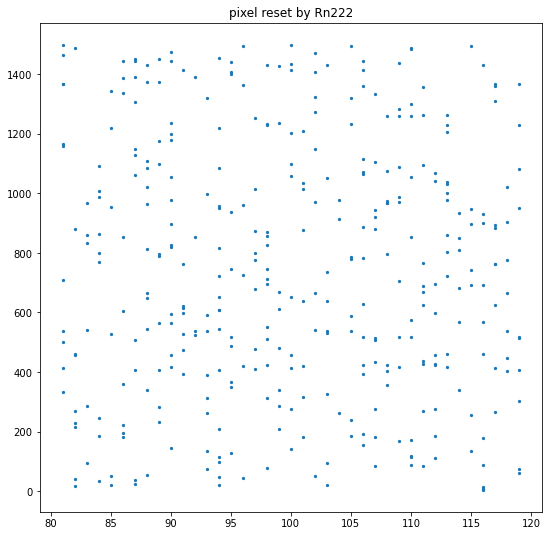

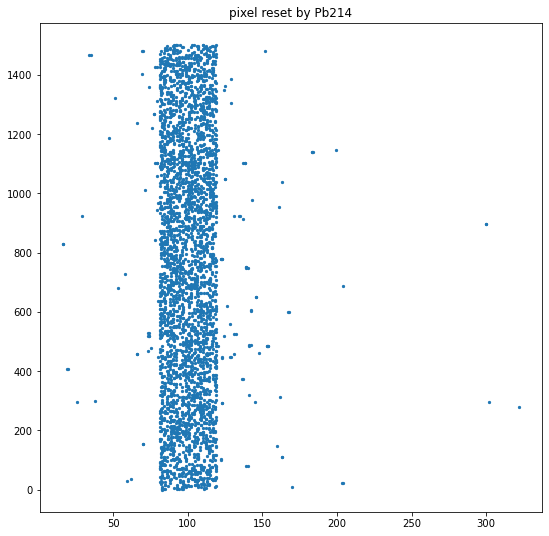

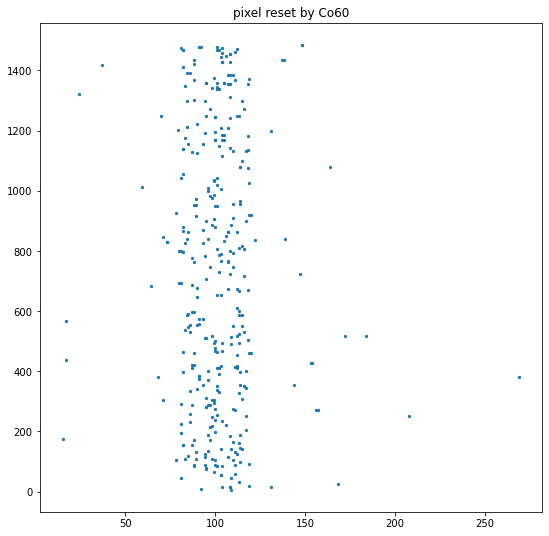

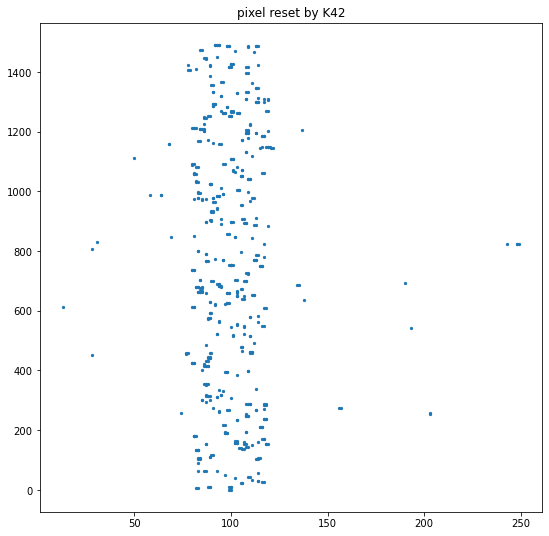

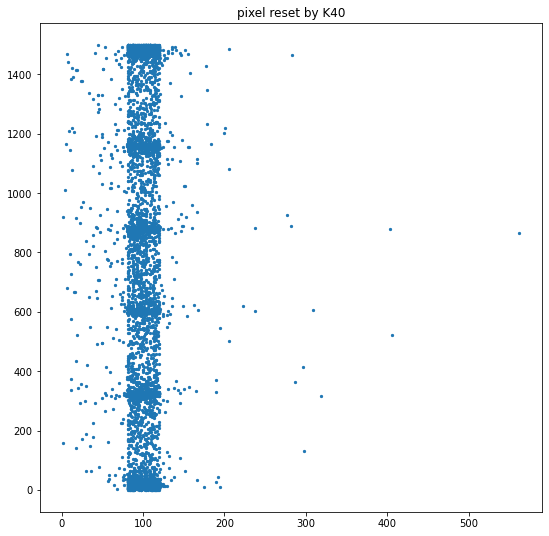

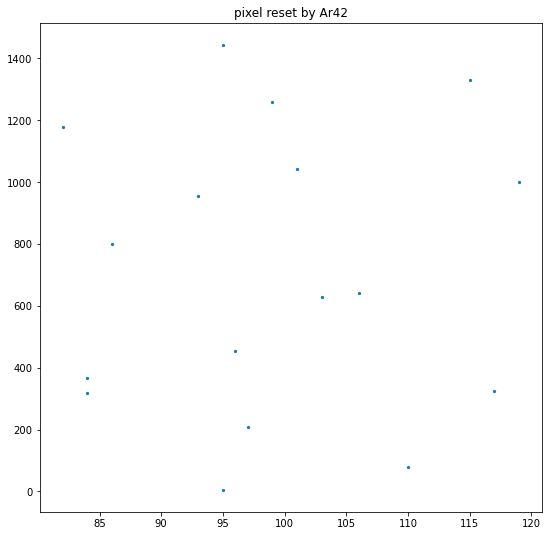

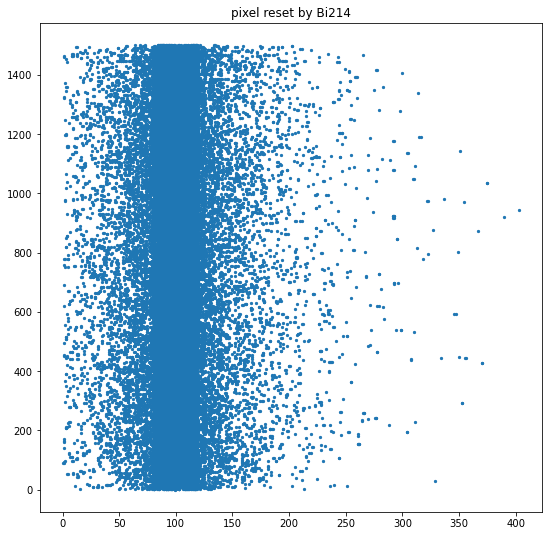

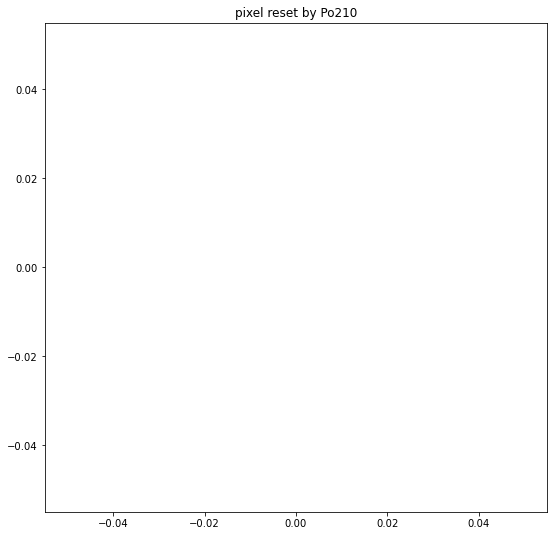

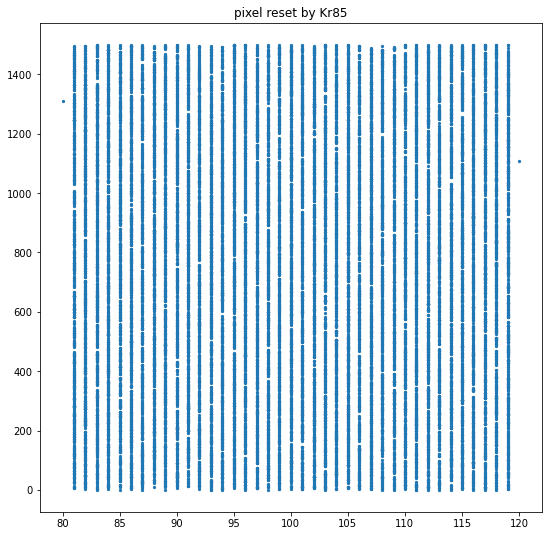

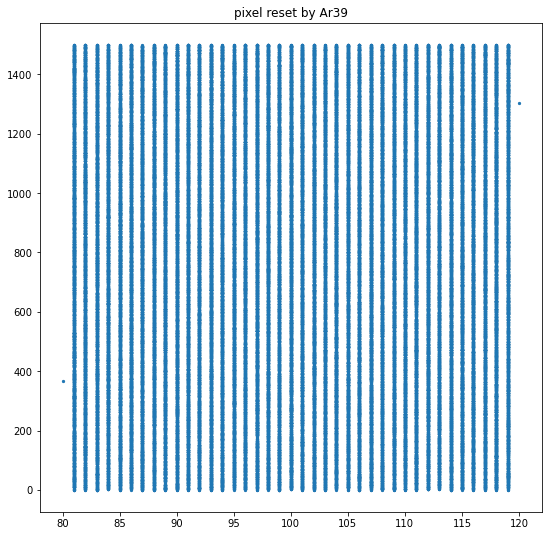

In [3]:
import matplotlib.pyplot as plt
import seaborn as sea
import numpy as np
import itertools


x_values = {}
y_values = {}

for key, entries in data.items():
    if not hasattr(x_values, f'{key}'):
        x_values[key] = []
        y_values[key] = []

    x_values[key] = list(itertools.chain(*data[key]['pixel_x']))
    y_values[key] = list(itertools.chain(*data[key]['pixel_y']))

    # for value in data[key]['pixel_x']:
    #     x_values[key].append(value)
    # for value in data[key]['pixel_y']:
    #     y_values[key].append(value)
    
    plt.figure(figsize = (9, 9))
    plt.scatter(x_values[key], y_values[key], s=5)
    plt.title(f'pixel reset by {key}')

    # sea.scatterplot(x_values[key], y_values[key], hue=data[key]['pixel_reset'])
# for key in x_values.keys():
#     print()
#     if (len(x_values[key])):
#         print(key)
#         print(max(x_values[key]))
#         print(max(y_values[key]))
#     else:
#         continue


In [16]:
class pixelHits():
    def __init__(self, x, y, hitTimes, ion):
        self.x = x
        self.y = y
        self.hitTimes = hitTimes
        self.ion = ion

ListOfPixelHits = []

for ion in data.keys():
    for ind, dastuff in enumerate(data[ion]['pixel_reset']):
        x = data[ion]['pixel_x'][ind]
        y = data[ion]['pixel_y'][ind]

        if not(len(x) > 1):
            ResetTimes = []
            for i in data[ion]['pixel_reset'][ind]:
                for j in i:
                    ResetTimes.append(j)
            newObj = pixelHits(x=x[0], y=y[0], hitTimes=ResetTimes, ion=ion)
            ListOfPixelHits.append(newObj)
            

        else:
            for n, m in zip(x, y):
                # print(f'n is {n} and m is {m}')
                ResetTimes = []
                for i in data[ion]['pixel_reset'][ind]:
                    for j in i:
                        ResetTimes.append(j)

                newObj = pixelHits(x=n, y=m, hitTimes=ResetTimes, ion=ion)
                ListOfPixelHits.append(newObj)

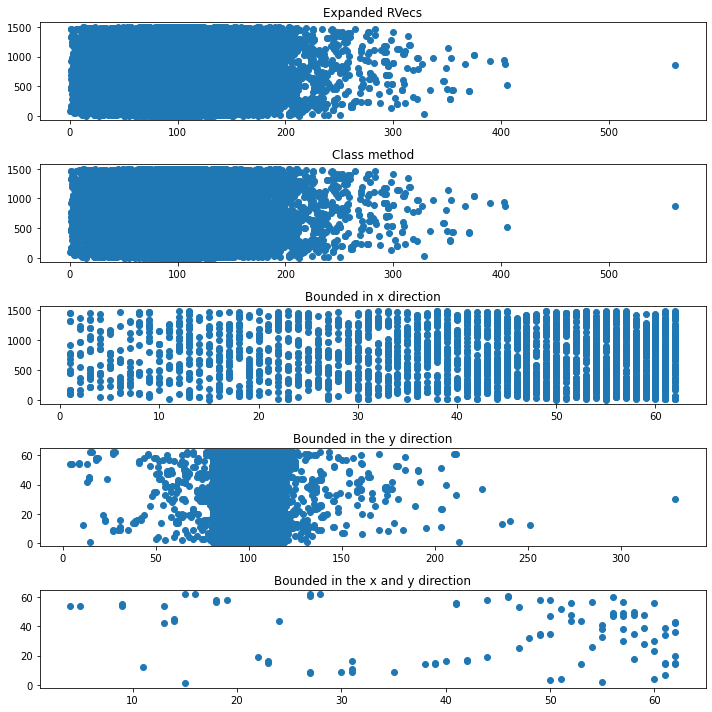

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import sys

# TESTING IF THE DATA MATCHES
fig, ax = plt.subplots(5, 1, figsize=(10, 10))
x_values = {}
y_values = {}
pixel_reset = {}

for key, entries in data.items():
    if not hasattr(x_values, f'{key}'):
        x_values[key] = []
        y_values[key] = []
        pixel_reset[key] = []

    x_values[key] = list(itertools.chain(*data[key]['pixel_x']))
    y_values[key] = list(itertools.chain(*data[key]['pixel_y']))

    ax[0].scatter(x_values[key], y_values[key], color='#1f77b4')
    ax[0].set_title('Expanded RVecs')

#Numpy way 
x_val = np.zeros_like(ListOfPixelHits)
y_val = np.zeros_like(ListOfPixelHits)
pixelz = np.zeros_like(ListOfPixelHits)
for ind, i in enumerate(ListOfPixelHits):
    x_val[ind] = i.x
    y_val[ind] = i.y
    pixelz[ind] = i.hitTimes
ax[1].scatter(x_val, y_val)
ax[1].set_title('Class method')

XLogicalArray = np.logical_and(x_val > 0, x_val < 62.5)
ax[2].scatter(x_val[XLogicalArray], y_val[XLogicalArray])
ax[2].set_title('Bounded in x direction')
YLogicalArray = np.logical_and(y_val > 0, y_val < 62.5)
ax[3].scatter(x_val[YLogicalArray], y_val[YLogicalArray])
ax[3].set_title('Bounded in the y direction')

LogicalArray = np.logical_and(YLogicalArray, XLogicalArray)
ax[4].scatter(x_val[LogicalArray], y_val[LogicalArray])
ax[4].set_title('Bounded in the x and y direction')

plt.tight_layout()
